In [839]:
import matplotlib as mpl
import numpy as np
import scipy 
import pickle
import pylab as plt
import copy
import pandas as pd
from pathlib import Path
%matplotlib inline
import csv   

#### Script Description

This script takes in the MCeQ flux file and converts into a csv format
along with the bin edges.

In [840]:
# Load in the files
f=open("./MCEqFluxMeshes.pkl","rb")
EBins, cosas, bs, FluxMeshes= pickle.load(f)
f.close()

f=open("./LinInterps.pkl","rb")
LinInterps=pickle.load(f)
f.close()

LinInterps.keys()

dict_keys([100, 300, 400, 450, 500, 550, 600, 650, 700, 800, 900, 1000, 2000, 4000, 6000])

In [841]:
eps=0.01
survivalfractions=[]
correctedmeshes=[]

for ei in range(0,len(EBins)-2):
    
    mesh=copy.copy(FluxMeshes[ei])
    survmesh=np.zeros_like(mesh)
    
    for ica in range(len(cosas)):
    
        for ib in range(len(bs)):
            surv=LinInterps[EBins[ei]](cosas[ica]+eps,bs[ib])
            survmesh[ica,ib]=surv
            mesh[ica,ib]=mesh[ica,ib]*surv
    
    correctedmeshes.append(mesh)
    survivalfractions.append(survmesh)

In [842]:
intensity = []
azimuth      = []
zenith     = []


cosa_mesh, b_mesh=np.meshgrid(cosas, bs)
zenith_=np.arccos(cosas-4e-16) # 4e-16 factor introduced to remove erroneous cosas > 1

totalflux=np.zeros_like(correctedmeshes[0])
for m in correctedmeshes:
    totalflux+=m


# Loop over the flux bins and get zenith and azimuth values to save to file
for y in range(0, len(totalflux)):
    for x in range(0, len(totalflux[y])):

        temp_az = bs[x]+np.pi+10*np.pi/180.0  # Add the extra 10 degrees so it aligns with the data
        temp_intensity = totalflux[y][x]

        if(temp_az > 2*np.pi): temp_az = temp_az - 2*np.pi

        if (zenith_[y] > 0 and bs[x]+np.pi > 0):
            intensity.append(temp_intensity)
            azimuth.append(temp_az)
            zenith.append(zenith_[y])

# Create a dictionary of the intensity, zenith and azimuth values to store
dict_ = {'Intensity':intensity, 'azimuth': azimuth, 'zenith': zenith}

# Dataframe from the dictionary
dataframe = pd.DataFrame(dict_)

# Write the data from hdf5 format to csv for reading into nexus
filepath = Path('SimulatedMuonsProposalMCEq.csv')  
dataframe.to_csv(filepath, index = False, header = False)  

# Save the bin edges to the file too

# Bin edges
binEdges_zenith_ = np.linspace(0.4, 1, 30)
binEdges_zenith_ = binEdges_zenith_[::-1]
binEdges_zenith = np.arccos(binEdges_zenith_)

binEdges_azimuth = np.linspace(0, 2*np.pi, 30)

with open(r'SimulatedMuonsProposalMCEq.csv', 'a') as f:
    writer = csv.writer(f)
    
    # Write the zenith bin edges
    for i in range(len(binEdges_zenith)):
        writer.writerow(['zenith', binEdges_zenith[i]])

    # Write the zenith bin edges
    for i in range(len(binEdges_azimuth)):
        writer.writerow(['azimuth',binEdges_azimuth[i]])


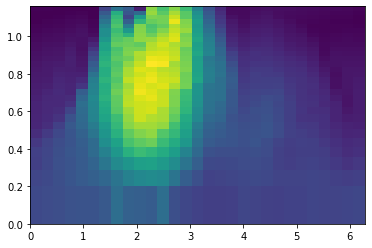

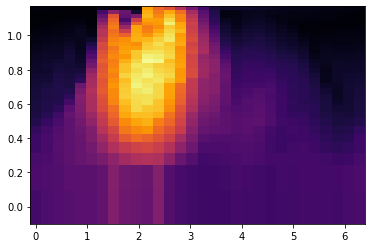

In [843]:
# Plot the histogram as a test
h, xedges, yedges, image = hist_data= plt.hist2d(dataframe["azimuth"], dataframe["zenith"], weights=dataframe["Intensity"], bins=[binEdges_azimuth, binEdges_zenith]) 
plt.figure()
im=plt.pcolormesh(bs+np.pi,zenith_,totalflux,cmap='inferno',shading='auto',vmin=0,vmax=3e-7)

# print(np.random.rand(340,2)*5)
# print(im.get_array())

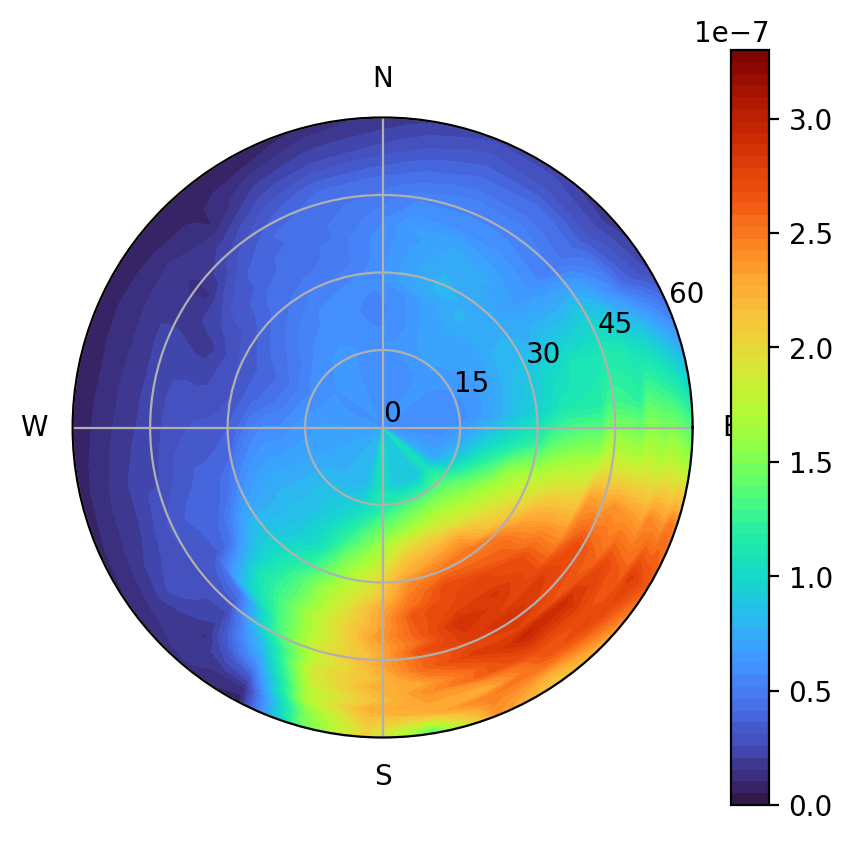

In [844]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'),figsize=(5,5),dpi=200)
fig.patch.set_facecolor('white')
levels=np.linspace(0,3.3e-7,65)
im=ax.contourf(bs, np.arccos(cosas-4e-16)*180/3.14, totalflux,cmap='turbo',levels=levels)
ax.set_rlim(0,60)
ax.set_rticks([0,15,30,45,60])
plt.colorbar(im,ticks=np.arange(0,3.5e-7,5e-8))
ax.set_thetagrids([0,90,180,270],['E','N','W','S'])
ax.set(facecolor = "lightgrey",alpha=0.2)
plt.show()